# Lesson 3 - Random forest from scratch

> A walkthrough on how to write a Random Forest classifier from scratch.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/lewtun/hepml/master?urlpath=lab/tree/notebooks%2Flesson03_random-forest-from-scratch.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lewtun/hepml/blob/master/notebooks/lesson03_random-forest-from-scratch.ipynb)

## Learning objectives

* Gain an in-depth understanding on how Random Forests work under the hood
* Understand the basics of object-oriented-programming (OOP) in Python
* Gain an introduction to computational complexity and the steps one can take to optimise an algorithm for speed

## References

This lesson adapts the implementation for regression trees from 

* Lessons 5 & 7 from Jeremy Howard's [_Practical Machine Learning for Coders_](http://course18.fast.ai/ml.html) course

to binary classificaion tasks. You may also find the following references useful for conceptual understanding:

* [_Machine Learning Recipes #8_](https://www.youtube.com/watch?time_continue=492&v=LDRbO9a6XPU&feature=emb_logo) by Josh Gordon
* [A visual introduction to machine learning](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/) by Stephanie Yee and Tony Chu
* [_Object-Oriented Programming (OOP) in Python 3_](https://realpython.com/python3-object-oriented-programming/) by Real Python

## The data

We will continue to use the [SUSY dataset](http://archive.ics.uci.edu/ml/datasets/SUSY#) from lesson 1, but this time using a random sample of 100,000 events:

* `susy_sample.feather`


## Import libraries

In [ ]:
# reload modules before executing user code
%load_ext autoreload
# reload all modules every time before executing Python code
%autoreload 2
# render plots in notebook
%matplotlib inline

In [ ]:
# uncomment this if running locally or on Google Colab
# !pip install --upgrade hepml

In [ ]:
# data wrangling
import pandas as pd
import numpy as np
from pathlib import Path
from hepml.core import display_large, download_dataset

# data viz
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# ml magic
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

## Plan of attack

<div style="text-align: center">
<img src='images/wtf.jpg'>
   <p style="text-align: center;"> <b>Figure reference:</b> https://bit.ly/2S7XuJP </p>
</div>

A good strategy when implementing any algorithm from scratch is to compare against an existing implementation.  This is especially true for machine learning algorithms, where there's many ways to _fail silently_ by introducing bugs in the data manipulation steps that do not throw an error, but result in worse performance in the target metric.

To that end, we will use the same sample of 100,000 events from the SUSY dataset that we analysed in lessons 1 and 2, and to simplify the analysis during development we'll start by picking just two features to build our Random Forest on. At each step, we will compare our implementation against scikit-learn's [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) as a way of testing the correctness of our code.

## Load the data

As usual, we can download our dataset by using our `download_dataset` helper function:

In [ ]:
download_dataset("susy_sample.feather")

Download of susy_sample.feather dataset complete.


In [ ]:
DATA = Path("../data")
!ls {DATA}

susy.csv.gz         susy_sample.feather susy_train.feather
susy.feather        susy_test.feather


With pathlib it is a simple matter to define the filepath to the dataset, and since the file is in Feather format we can load it as a `pandas.DataFrame` as follows:

In [ ]:
susy_sample = pd.read_feather(DATA / "susy_sample.feather")
susy_sample.head()

,signal,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,1.0,0.821395,-0.103436,0.168752,1.051992,0.431800,-1.210648,0.428240,-1.663188,0.475450,-0.020242,0.795758,0.704858,0.786029,0.776712,0.792950,0.623655,0.770409,0.196300
1,1.0,0.907188,-1.143420,1.317695,1.299381,-1.839876,-0.160823,0.988608,-0.829973,1.395849,-0.646217,0.963228,1.139413,1.049706,1.399592,1.019565,1.157555,1.484495,0.179817
2,0.0,0.659807,-1.977303,-1.410509,0.990329,-1.701409,0.249222,0.499979,-0.509796,0.737884,0.661397,0.659569,0.609093,0.819481,0.000000,0.671145,0.397877,1.439343,0.054367
3,0.0,0.720814,-0.863228,0.222717,0.502039,0.472637,-1.134090,0.829423,-1.630658,0.984676,-0.509003,0.685277,0.898880,1.163993,0.885574,0.733956,0.942846,1.475507,0.365486
4,1.0,0.672261,1.264989,-0.032661,0.560856,0.086291,1.542801,1.705778,0.219045,1.099387,2.002287,0.646456,0.835348,1.146685,0.000000,0.692432,0.779301,1.543818,0.308604


In [ ]:
# sanity check on number of events
assert len(susy_sample) == 100_000

Next we create the feature matrix $X$ and target vector $y$, along with the training and validation sets:

In [ ]:
X = susy_sample.drop("signal", axis=1)
y = susy_sample["signal"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dataset split: {len(X_train)} train rows + {len(X_valid)} valid rows")

# pick 2 features to experiment with
X_train_sub = X_train[["missing energy magnitude", "lepton 1 pT"]].copy()
X_valid_sub = X_valid[["missing energy magnitude", "lepton 1 pT"]].copy()

Dataset split: 80000 train rows + 20000 valid rows


## Basic classes and functions

### Tree ensemble

To get started, we need a data structure that will represent an ensemble of decision trees. As a first guess, the variables we'll need to initialise our ensemble might include:

* `X`: the feature matrix
* `y`: the target vector
* `n_trees`: how many trees to include in the forest
* `sample_size`: how big we want each sample to be
* `min_samples_leaf`: some optional hyperparameter that controls the minimum number of samples required to be at a leaf node

With these considerations, let's go ahead and build our ensemble class

In [ ]:
class TreeEnsemble:
    # instance attributes
    def __init__(
        self, X: np.ndarray, y: np.ndarray, n_trees: int, sample_size: int, min_samples_leaf: int = 5,
    ):
        # use constant random seed for testing
        np.random.seed(42)
        self.X = X
        self.y = y
        self.n_trees = n_trees
        self.sample_size = sample_size
        self.min_samples_leaf = min_samples_leaf

        self.trees = [self.create_tree() for i in range(n_trees)]

    # instance method
    def create_tree(self):
        # grab random subsample without replacement - no bootstrapping!
        random_indices = np.random.permutation(len(self.y))[: self.sample_size]
        return DecisionTree(
            self.X.iloc[random_indices], self.y.iloc[random_indices], min_samples_leaf=self.min_samples_leaf,
        )

    # instance method
    def predict(self, X):
        return np.mean([t.predict(X) for t in self.trees], axis=0)

> Note: All classes in Python create objects, and all objects contain properties called attributes. We use the `__init__()` method to initialize an object’s initial attributes by giving them their default value. This method must have at least one argument as well as the `self` variable, which refers to the object itself (e.g., `TreeEnsemble`).

Next let's try to instantiate this class:

In [ ]:
rf = TreeEnsemble(X_train_sub, y_train, n_trees=10, sample_size=1000, min_samples_leaf=3)

NameError: name 'DecisionTree' is not defined

Oops! Our `TreeEnsemble` assumes we have a class called `DecisionTree`, so let's create a minimal version that will allow us to instantiate it:

In [ ]:
class DecisionTree:
    def __init__(self, X: np.ndarray, y: np.ndarray, indices=None, min_samples_leaf: int = 5):
        self.X = X
        self.y = y
        self.indices = indices
        self.min_samples_leaf = min_samples_leaf

In [ ]:
rf = TreeEnsemble(X_train_sub, y_train, n_trees=10, sample_size=1000, min_samples_leaf=3)
# test we can access attributes
rf.trees

### Decision tree

Our `DecisionTree` class doesn't do anything yet, so let's add some logic to flesh it out. In addition to passing `X`, `y`, and `min_samples_leaf` to the constructor, we also need to keep track of which row indices are passed to the left- and right-hand sides of the tree. Since the root node contains all the rows, we can use `None` as a default and set `indices` to the length of `y`:

In [ ]:
class DecisionTree:
    def __init__(self, X: np.ndarray, y: np.ndarray, indices: np.ndarray = None, min_samples_leaf: int = 5):
        # use all rows for root node
        if indices is None:
            indices = np.arange(len(y))

        self.X = X
        self.y = y
        self.indices = indices
        self.min_samples_leaf = min_samples_leaf

        self.n_samples, self.n_features = len(indices), X.shape[1]
        self.value = self.calculate_class_probabilities(self.y, self.indices)
        self.gini = self.gini_impurity(self.y)
        self.score = float("inf")
        self.find_feature_split()

    # this just does one decision - we'll make it recursive later
    def find_feature_split(self):
        for i in range(self.n_features):
            self.find_better_split(i)

    # we'll write this later!
    def find_better_split(self, feature_index):
        pass

    # we'll write this later!
    def calculate_class_probabilities(self, y, indices):
        pass

    # we'll write this later!
    def gini_impurity(self, y):
        pass

    @property
    def split_name(self):
        return self.X.columns[self.feature_index]

    @property
    def split_feature(self):
        return self.X.values[self.indices, self.feature_index]

    @property
    def is_leaf(self):
        return self.score == float("inf")

    # convert object to string - see https://dbader.org/blog/python-repr-vs-str
    def __repr__(self):
        s = f"n_samples: {self.n_samples}; value: {self.value}; gini: {self.gini}"
        if not self.is_leaf:
            s += f"; score: {self.score}; feature: {self.split_name}; split_point: {self.split}"
        return s

Next let's check we can instantiate the ensemble and access the first decision tree:

In [ ]:
rf = TreeEnsemble(X_train_sub, y_train, n_trees=10, sample_size=1000, min_samples_leaf=3)
rf.trees[0]

n_samples: 1000; value: None; gini: None

It works! Our `__repr__` method now returns useful information about the attributes of the class instance, but we still need to implement methods for the class probabilities and Gini impurity. Let's consider each one in turn.

### Class probabilities

In order to average the predictions across multiple trees in our forest, we need know what percentage of a given leaf node contains signal events and what percentage contains background. A simple way to do that is via the `np.unique` method, e.g.

In [ ]:
# returns tuple - (class_labels, class_counts)
np.unique(y_train, return_counts=True)

(array([0., 1.]), array([43374, 36626]))

This is not quite what we need because it just provides the raw counts, so let's normalise them as follows:

In [ ]:
np.unique(y_train, return_counts=True)[1] / len(y_train)

array([0.542175, 0.457825])

We can wrap this in a single function that also handles the cases where we only have one sample in a leaf node:

In [ ]:
def calculate_class_probabilities(self, y: pd.Series, indices: np.ndarray):
    probs = np.unique(y.iloc[indices], return_counts=True)[1] / len(y.iloc[indices])

    # handle edge case when leaf only contains one sample
    if len(probs) == 1:
        if int(y.iloc[indices].values[0]) == 0:
            value = np.array([1.0, 0.0])
        else:
            value = np.array([0.0, 1.0])
    else:
        value = probs

    return value

We can now use this function to override our class method as follows:

In [ ]:
DecisionTree.calculate_class_probabilities = calculate_class_probabilities

Finally, let's check that the function works as intended:

In [ ]:
rf = TreeEnsemble(X_train_sub, y_train, n_trees=10, sample_size=1000, min_samples_leaf=3)
rf.trees[0]

n_samples: 1000; value: [0.516 0.484]; gini: None

### Gini impurity

The next piece of information we need to calculate is the Gini impurity at a given node in the tree. Recall that the formula for Gini impurity is

$$ G_i = 1 - \sum_{k=1}^n p_{i,k}^2 $$

where $p_{i,k}$ is the ratio of class $k$ examples among the training examples in the ith node. We can get the values of $p_{i,k}$ by using the `np.unique` method again, e.g.

In [ ]:
y_pure = np.array([1, 1, 1, 1])
y_mixed = np.array([1, 0, 1, 0])

gini_pure = 1.0 - np.sum((np.unique(y_pure, return_counts=True)[1] / len(y_pure)) ** 2)
gini_mixed = 1.0 - np.sum((np.unique(y_mixed, return_counts=True)[1] / len(y_mixed)) ** 2)

print(f"Gini pure = {gini_pure}; Gini mixed = {gini_mixed}")

Gini pure = 0.0; Gini mixed = 0.5


Let's wrap this logic in a function and override the one defined in our `DecisionTree` class:

In [ ]:
def gini_impurity(self, y):
    return 1.0 - np.sum((np.unique(y, return_counts=True)[1] / len(y)) ** 2)


DecisionTree.gini_impurity = gini_impurity

As before, we do a sanity check to see whether it works:

In [ ]:
rf = TreeEnsemble(X_train_sub, y_train, n_trees=10, sample_size=1000, min_samples_leaf=3)
rf.trees[0]

n_samples: 1000; value: [0.516 0.484]; gini: 0.49948800000000004

🎉🎉🎉

## Finding the best split on a single branch

Now that we are able to calculate the probabilities and Gini impurity of a Decision Tree's node, the next step is to implement the logic for the `find_better_split` function. To test that we are on the right track, let us first feed the same random sample from our ensemble to scikit-learns' `RandomForestClassifier`:

In [ ]:
# create ensemble with 1 tree
rf = TreeEnsemble(X_train_sub, y_train, n_trees=1, sample_size=1000)
# extract DecisionTree instance
tree = rf.trees[0]
# extract sample associated with the Decision Tree
X_samp, y_samp = tree.X, tree.y
X_samp.columns

Index(['missing energy magnitude', 'lepton 1 pT'], dtype='object')

In [ ]:
# create Decision Tree with same configuration as our algorithm
model = RandomForestClassifier(n_estimators=1, max_depth=1, bootstrap=False, random_state=42, max_features=None)
model.fit(X_samp, y_samp)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

To aid with the comarison, let's also create a plotting function so we can visualise the nodes of our decision trees:

In [ ]:
def draw_tree(fitted_model):
    # get column names
    feature_names = X_train_sub.columns
    # define class names
    class_names = ["Background", "Signal"]
    fig, ax = plt.subplots(figsize=(30, 10))
    # generate tree plot
    plot_tree(
        fitted_model.estimators_[0],
        filled=True,
        feature_names=feature_names,
        class_names=class_names,
        ax=ax,
        fontsize=18,
        proportion=True,
    )
    plt.show()

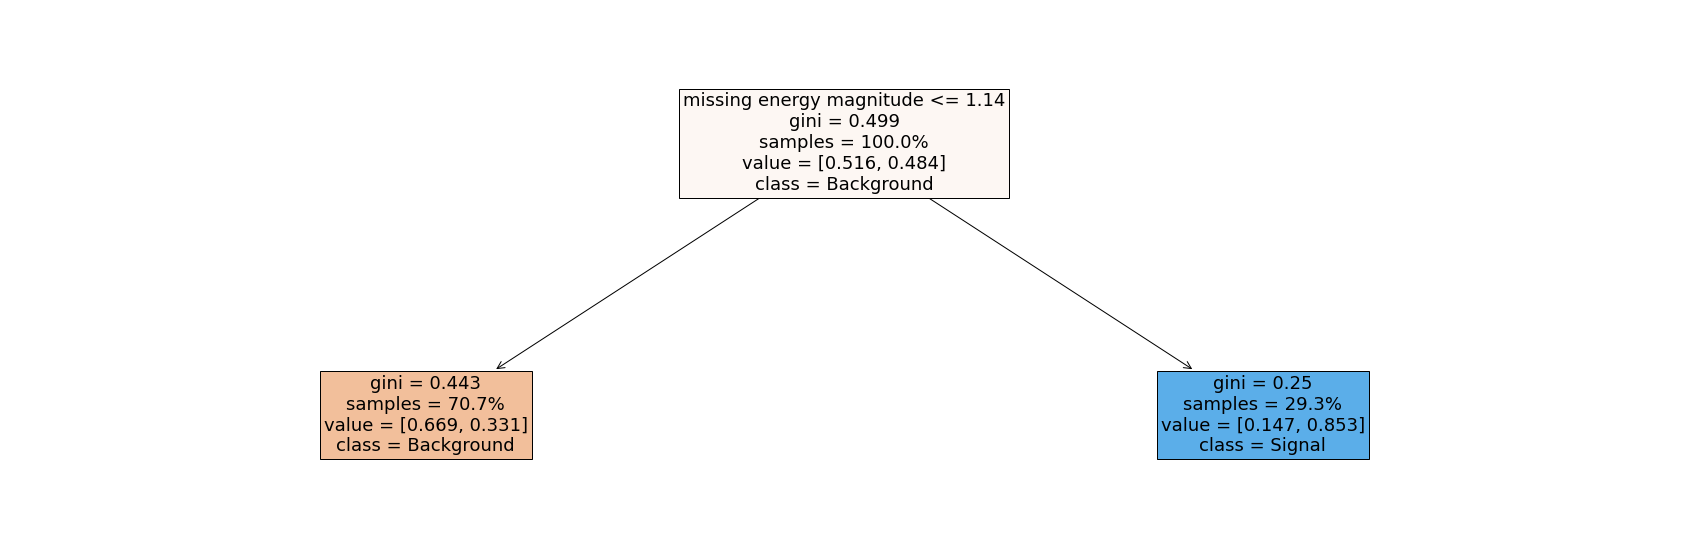

In [ ]:
draw_tree(model)

To recreate this split, recall that scikit-learn uses the Classification And Regression Tree (CART) algorithm to train Decision Trees. Here the key idea is to search for the pair `(feature, split_point)` the produces the purest subsets, as measured by their Gini impurity. The function to minimise is given by

$$ J(k, t_k) = \frac{m_\mathrm{left}}{m} G_\mathrm{left} + \frac{m_\mathrm{right}}{m}G_\mathrm{right} $$

where $k$ is a single feature, $t_k$ is the split point (e.g. "missing energy magnitude $\leq$ 1.14), $m_\mathrm{left/right}$ is the number of examples in the left/right subset, and $G_\mathrm{left/right}$ is the Gini impurity. Thus for each feature $k$, the strategy will be to calculate $J(k, t_k)$ for every possible split point $t_k$ and update the score if it less than what we have seen already. Implemented as code, the result could look like:

In [ ]:
def find_better_split(self, feature_index):
    # get sample for a single feature
    X, y = self.X.values[self.indices, feature_index], self.y.iloc[self.indices]

    for t in range(self.n_samples):
        # create boolean masks for samples above / below the split point t
        lhs = X <= X[t]
        rhs = X > X[t]

        # continue if stopping criterion not reached
        if rhs.sum() < self.min_samples_leaf or lhs.sum() < self.min_samples_leaf:
            continue

        # calculate Gini impurities for left and right nodes
        lhs_gini = gini_impurity(self, y[lhs])
        rhs_gini = gini_impurity(self, y[rhs])
        # calculate score for current split point
        curr_score = lhs_gini * len(y[lhs]) / len(y) + rhs_gini * len(y[rhs]) / len(y)
        # update attributes if new score is smaller than old
        if curr_score < self.score:
            self.feature_index, self.score, self.split, self.gini = (
                feature_index,
                curr_score,
                X[t],
                gini_impurity(self, y),
            )

Let's check this works by first calculating the best split point for `lepton 1 pT`:

In [ ]:
%timeit find_better_split(tree, feature_index=1)
tree

4 s ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


n_samples: 1000; value: [0.516 0.484]; gini: 0.49948800000000004; score: 0.406274337005304; feature: lepton 1 pT; split_point: 0.8724983930587769

Similarly for `missing energy magnitude` we find:

In [ ]:
find_better_split(tree, feature_index=0)
tree

n_samples: 1000; value: [0.516 0.484]; gini: 0.49948800000000004; score: 0.3864820927729048; feature: missing energy magnitude; split_point: 1.1392959356307983

It works! We see that `missing energy magnitude` has a lower score (i.e. cost $J$) than `lepton 1 pT`, and produces class probabilities and a Gini impurity consistent with scikit-learn. The downside is that our implementation is _slow_ - we can do better.

### Speeding things up

One problem with our implementation above is that we're repeatedly checking whether every value is greater or less than a given split point $t_k$. We can speed up the algorithm by first _sorting_ the arrays and then observing that we can compute the Gini impurities efficiently by finding the index that separates the two groups (i.e. signal vs background).

To that end, let's reset our Decision Tree:

In [ ]:
tree = TreeEnsemble(X_train_sub, y_train, 1, 1000).trees[0]

In [ ]:
def find_better_split(self, feature_index):
    X, y = self.X.values[self.indices, feature_index], self.y.values[self.indices]

    sorted_indices = np.argsort(X)
    y_sorted, X_sorted = y[sorted_indices], X[sorted_indices]
    index = 0

    for i in range(0, self.n_samples - self.min_samples_leaf):
        index += 1
        Xi = X_sorted[i]
        # continue if stopping criterion not reached
        if i < self.min_samples_leaf - 1 or Xi == X_sorted[i + 1]:
            continue

        # calculate Gini impurities for left and right nodes
        lhs_gini = gini_impurity(self, y_sorted[:index])
        rhs_gini = gini_impurity(self, y_sorted[index:])
        # calculate score for current split point
        curr_score = lhs_gini * len(y_sorted[:index]) / len(y_sorted) + rhs_gini * len(y_sorted[index:]) / len(y_sorted)
        # update attributes if new score is smaller than old
        if curr_score < self.score:
            self.feature_index, self.score, self.split, self.gini = (
                feature_index,
                curr_score,
                X_sorted[i],
                gini_impurity(self, y),
            )

In [ ]:
%timeit find_better_split(tree, feature_index=1)
tree

64.8 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


n_samples: 1000; value: [0.516 0.484]; gini: 0.49948800000000004; score: 0.406274337005304; feature: lepton 1 pT; split_point: 0.8724983930587769

Not bad - we've reduced the complexity of our original algorithm from $O(n^2)$ to $O(n)$ to gain roughly a factor of 60x speed up! Let's check we recover the same result for `missing energy magnitude` as before:

In [ ]:
find_better_split(tree, feature_index=0)
tree

n_samples: 1000; value: [0.516 0.484]; gini: 0.49948800000000004; score: 0.3864820927729048; feature: missing energy magnitude; split_point: 1.1392959356307983

Finally, we can override the function in our `DecisionTree` class so we can access it from our `TreeEnsemble`:

In [ ]:
DecisionTree.find_better_split = find_better_split

In [ ]:
tree = TreeEnsemble(X_train, y_train, 1, 1000).trees[0]
tree

n_samples: 1000; value: [0.516 0.484]; gini: 0.49948800000000004; score: 0.3864820927729048; feature: missing energy magnitude; split_point: 1.1392959356307983

## Growing the full decision tree

So far we have worked out how to find the best split point for single now - we are now ready to tackle building the whole tree! Let's increase the depth in our scikit-learn model to compare against:

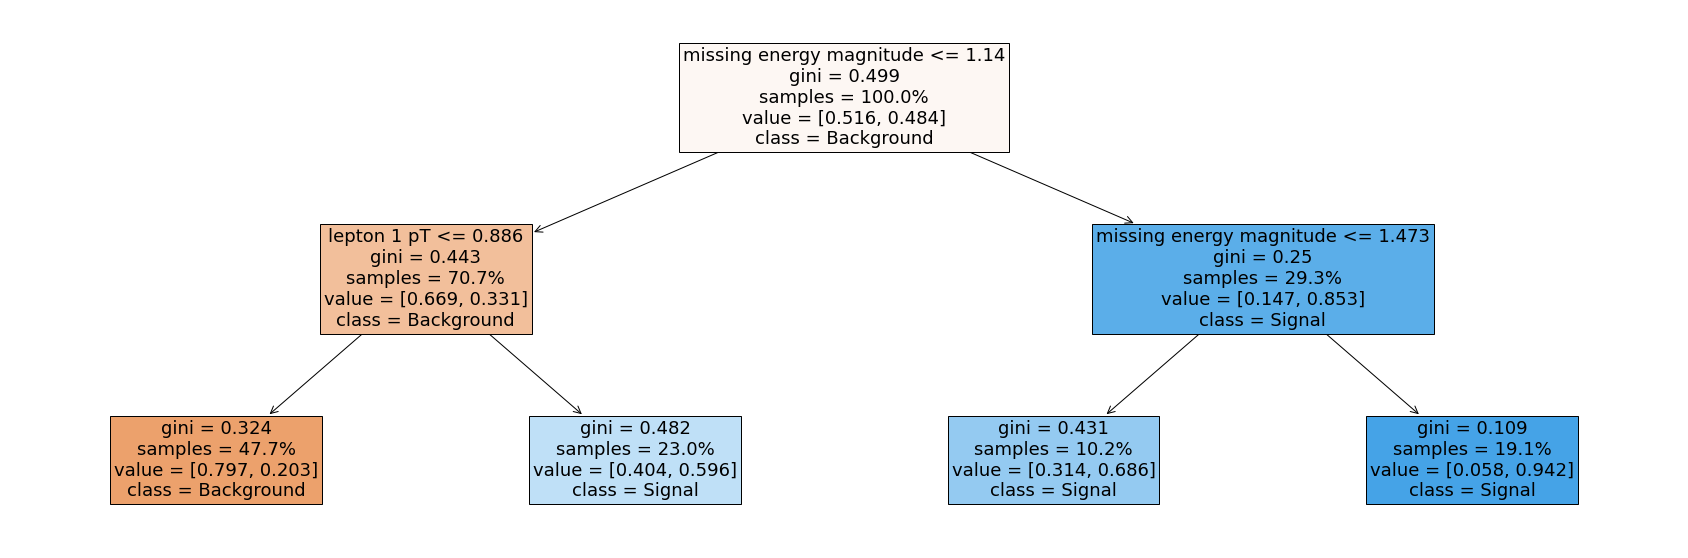

In [ ]:
model = RandomForestClassifier(n_estimators=1, max_depth=2, bootstrap=False, random_state=42, max_features=None)
model.fit(X_samp, y_samp)

draw_tree(model)

Recall that our `DecisionTree` class has a simple function to find the best split:

```python
def find_feature_split(self):
    for i in range(self.n_features):
        self.find_better_split(i)
```
This is not quite sufficient it only checks for the best split at the root node, when in fact we need to check whether is a better split in the left and right child nodes. The following change to the code takes care of this:

In [ ]:
def find_feature_split(self):
    for i in range(self.n_features):
        self.find_better_split(i)

    if self.is_leaf:
        return

    X = self.split_feature
    # grab indices for left and right nodes
    lhs = np.nonzero(X <= self.split)[0]
    rhs = np.nonzero(X > self.split)[0]
    # recursively calculate decision trees for all nodes
    self.lhs = DecisionTree(self.X, self.y, self.indices[lhs])
    self.rhs = DecisionTree(self.X, self.y, self.indices[rhs])

Now we can override the function in our class and test we can reproduce the numbers in our scikit-learn tree:

In [ ]:
DecisionTree.find_feature_split = find_feature_split

In [ ]:
tree = TreeEnsemble(X_samp, y_samp, 1, 1000).trees[0]
tree

n_samples: 1000; value: [0.516 0.484]; gini: 0.49948800000000004; score: 0.3864820927729048; feature: missing energy magnitude; split_point: 1.1392959356307983

In [ ]:
tree.lhs

n_samples: 707; value: [0.66902405 0.33097595]; gini: 0.4428617442467625; score: 0.3753049089041096; feature: lepton 1 pT; split_point: 0.8853832483291628

In [ ]:
tree.rhs

n_samples: 293; value: [0.14675768 0.85324232]; gini: 0.2504397255646542; score: 0.22066400314213208; feature: missing energy magnitude; split_point: 1.4726196527481081

In [ ]:
tree.lhs.lhs

n_samples: 477; value: [0.7966457 0.2033543]; gini: 0.32400265460666544; score: 0.3118973109371423; feature: lepton 1 pT; split_point: 0.7281696796417235

In [ ]:
tree.lhs.rhs

n_samples: 230; value: [0.40434783 0.59565217]; gini: 0.4817013232514178; score: 0.4334455110107284; feature: lepton 1 pT; split_point: 1.5821422338485713

In [ ]:
tree.rhs.lhs

n_samples: 102; value: [0.31372549 0.68627451]; gini: 0.43060361399461744; score: 0.37738731856378904; feature: lepton 1 pT; split_point: 0.6343935132026673

In [ ]:
tree.rhs.rhs

n_samples: 191; value: [0.05759162 0.94240838]; gini: 0.10854965598530741; score: 0.1032951765936059; feature: missing energy magnitude; split_point: 1.6436718702316286

Hooray, it works 🥳🥳🥳!

## Generate predictions

Now that we have something that can train a Decision Tree, the next step is to implement the methods to generate predictions. Although we have `TreeEnsemble.predict` we do not have anything like this yet for `DecisionTree`. To make things more interesting, let's add a few more columns to our training set:

In [ ]:
cols = ["missing energy magnitude", "lepton 1 pT", "axial MET", "M_TR_2", "M_R", "S_R"]

X_train_sub = X_train[cols].copy()
X_valid_sub = X_valid[cols].copy()

Let's create our tree ensemble again to make sure we can compare against scikit-learn:

In [ ]:
%time tree = TreeEnsemble(X_train_sub, y_train, 1, 1000).trees[0]
X_samp, y_samp = tree.X, tree.y

CPU times: user 13.1 s, sys: 289 ms, total: 13.4 s
Wall time: 13.8 s


In [ ]:
model = RandomForestClassifier(
    n_estimators=1, max_depth=None, bootstrap=False, max_features=None, random_state=42, min_samples_leaf=5,
)
model.fit(X_samp, y_samp)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

To generate the predictions, we simply need to loop over each row in $X$ and build the array as follows:

In [ ]:
def predict(self, X):
    return np.array([self.predict_row(Xi) for Xi in X])


DecisionTree.predict = predict

The final step is to implement `predict_row`, which is mostly trivial: if we're at a leaf note we return the class label with the highest probability, otherwise we figure out whether to traverse to the left or right child node, and so on:

In [ ]:
def predict_row(self, Xi):
    if self.is_leaf:
        return self.value
    t = self.lhs if Xi[self.feature_index] <= self.split else self.rhs
    return t.predict_row(Xi)


DecisionTree.predict_row = predict_row

With this we can now calculate our class probabilities:

In [ ]:
%time probs = tree.predict(X_valid_sub.values)[:, 1]

CPU times: user 246 ms, sys: 3.62 ms, total: 249 ms
Wall time: 251 ms


and evaluate the ROC AUC score on the validation set:

In [ ]:
roc_auc_score(y_valid, probs)

0.7603031405574215

How does this compare with scikit-learn's implementation? Let's find out by calculating their predictions and evaluating on the validation set:

In [ ]:
probs_sklearn = model.predict_proba(X_valid_sub)[:, 1]
roc_auc_score(y_valid, probs_sklearn)

0.76246534984286

With a difference of < 1%, our implementation does not perform too badly at all!

## Putting it together

Let's wrap this up by collecting all of our class functions into two dedicated classes:

In [ ]:
class TreeEnsemble:
    # instance attributes
    def __init__(
        self, X: np.ndarray, y: np.ndarray, n_trees: int, sample_size: int, min_samples_leaf: int = 5,
    ):
        # use constant random seed for testing
        np.random.seed(42)
        self.X = X
        self.y = y
        self.n_trees = n_trees
        self.sample_size = sample_size
        self.min_samples_leaf = min_samples_leaf

        self.trees = [self.create_tree() for i in range(n_trees)]

    # instance method
    def create_tree(self):
        # grab random subsample without replacement - no bootstrapping!
        random_indices = np.random.permutation(len(self.y))[: self.sample_size]
        return DecisionTree(
            self.X.iloc[random_indices], self.y.iloc[random_indices], min_samples_leaf=self.min_samples_leaf,
        )

    # instance method
    def predict(self, X):
        return np.mean([t.predict(X) for t in self.trees], axis=0)

In [ ]:
class DecisionTree:
    def __init__(self, X, y, indices=None, min_samples_leaf=5):
        # use all rows for root node
        if indices is None:
            indices = np.arange(len(y))

        self.X = X
        self.y = y
        self.indices = indices
        self.min_samples_leaf = min_samples_leaf

        self.n_samples, self.n_features = len(indices), X.shape[1]
        self.value = self.calculate_class_probabilities(self.y, self.indices)
        self.gini = self.gini_impurity(self.y)
        self.score = float("inf")
        self.find_feature_split()

    def find_feature_split(self):
        for i in range(self.n_features):
            self.find_better_split(i)

        if self.is_leaf:
            return

        X = self.split_feature
        # grab indices for left and right nodes
        lhs = np.nonzero(X <= self.split)[0]
        rhs = np.nonzero(X > self.split)[0]
        # recursively calculate decision trees for all nodes
        self.lhs = DecisionTree(self.X, self.y, self.indices[lhs])
        self.rhs = DecisionTree(self.X, self.y, self.indices[rhs])

    def find_better_split(self, feature_index):
        X, y = self.X.values[self.indices, feature_index], self.y.values[self.indices]

        sorted_indices = np.argsort(X)
        y_sorted, X_sorted = y[sorted_indices], X[sorted_indices]
        index = 0

        for i in range(0, self.n_samples - self.min_samples_leaf):
            index += 1
            Xi = X_sorted[i]
            # continue if stopping criterion not reached
            if i < self.min_samples_leaf - 1 or Xi == X_sorted[i + 1]:
                continue

            # calculate Gini impurities for left and right nodes
            lhs_gini = gini_impurity(self, y_sorted[:index])
            rhs_gini = gini_impurity(self, y_sorted[index:])
            # calculate score for current split point
            curr_score = lhs_gini * len(y_sorted[:index]) / len(y_sorted) + rhs_gini * len(y_sorted[index:]) / len(
                y_sorted
            )
            # update attributes if new score is smaller than old
            if curr_score < self.score:
                self.feature_index, self.score, self.split, self.gini = (
                    feature_index,
                    curr_score,
                    X_sorted[i],
                    gini_impurity(self, y),
                )

    def calculate_class_probabilities(self, y: pd.Series, indices: np.ndarray):
        probs = np.unique(y.iloc[indices], return_counts=True)[1] / len(y.iloc[indices])

        # handle edge case when leaf only contains one sample
        if len(probs) == 1:
            if int(y.iloc[indices].values[0]) == 0:
                value = np.array([1.0, 0.0])
            else:
                value = np.array([0.0, 1.0])
        else:
            value = probs

        return value

    def gini_impurity(self, y):
        return 1.0 - np.sum((np.unique(y, return_counts=True)[1] / len(y)) ** 2)

    def predict(self, X):
        return np.array([self.predict_row(Xi) for Xi in X])

    def predict_row(self, Xi):
        if self.is_leaf:
            return self.value
        t = self.lhs if Xi[self.feature_index] <= self.split else self.rhs
        return t.predict_row(Xi)

    @property
    def split_name(self):
        return self.X.columns[self.feature_index]

    @property
    def split_feature(self):
        return self.X.values[self.indices, self.feature_index]

    @property
    def is_leaf(self):
        return self.score == float("inf")

    # convert object to string - see https://dbader.org/blog/python-repr-vs-str
    def __repr__(self):
        s = f"n_samples: {self.n_samples}; value: {self.value}; gini: {self.gini}"
        if not self.is_leaf:
            s += f"; score: {self.score}; feature: {self.split_name}; split_point: {self.split}"
        return s

As a sanity check, let's evaluate the performance on a single tree:

In [ ]:
tree = TreeEnsemble(X_train_sub, y_train, n_trees=1, sample_size=1000).trees[0]
X_samp, y_samp = tree.X, tree.y

# calculate class probabilities
probs = tree.predict(X_valid_sub.values)[:, 1]
# evaluate
roc_auc_score(y_valid, probs)

0.7603031405574215

This matches our earlier result, so let's now roll-out to a full forest and compare against scikit-learn:

In [ ]:
%time rf = TreeEnsemble(X_train_sub, y_train, n_trees=5, sample_size=1000)

probs = rf.predict(X_valid_sub.values)[:, 1]
roc_auc_score(y_valid, probs)

CPU times: user 15.5 s, sys: 38.2 ms, total: 15.5 s
Wall time: 15.7 s


0.8309216956906361

In [ ]:
model = RandomForestClassifier(n_estimators=5, bootstrap=False, max_features=None, random_state=42, min_samples_leaf=5)
model.fit(X_train_sub, y_train)

probs_sklearn = model.predict_proba(X_valid_sub)[:, 1]
roc_auc_score(y_valid, probs_sklearn)

0.7794032635534188

The final results are not the same, but ours did a little better, possibly due to differences in how we average the predictions across trees. In any case, we can be happy that our implementation that we wrote entirely from scratch is competitive with a well tested implementation!

## Performance improvements with Cython and Numba

Although our Random Forest implementation did OK on the ROC AUC score, its runtime performance leaves a lot to be desired. One way we could improve this is by following scikit-learn, who typically implement their algorithms in [Cython](https://cython.org/), which allows you to generate efficient C code from Python. To use Cython in a Jupyter notebook we call the magic function:

In [ ]:
%load_ext Cython

and then can compare the pure Python function

In [ ]:
def fib1(n):
    a, b = 0, 1
    while b < n:
        a, b = b, a + b

In [ ]:
%timeit fib1(50)

478 ns ± 3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


against it's compiled version

In [ ]:
%%cython
def fib2(n):
    a, b = 0, 1
    while b < n:
        a, b = b, a + b

In [ ]:
%timeit fib2(50)

210 ns ± 4.99 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


We can gain even more performance gains by declaring the types explicitly:

In [ ]:
%%cython
def fib3(int n):
    cdef int b = 1
    cdef int a = 0
    cdef int t = 0
    while b < n:
        t = a
        a = b
        b = t + b

In [ ]:
%timeit fib3(50)

41.6 ns ± 1.21 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In practice, I find that [Numba](http://numba.pydata.org/) provides a powerful alternative to Cython and does away with the need to learn new data types etc. To use Numba one simply needs to import it and add a decorator to your functions:

In [ ]:
from numba import njit

In [ ]:
@njit
def fib4(n):
    a, b = 0, 1
    while b < n:
        a, b = b, a + b

In [ ]:
%timeit fib4(50)

109 ns ± 1.07 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


This is especially useful when working with NumPy functions, consider for example the generation of the Mandelbrot set using NumPy:

In [ ]:
# example from - https://ipython-books.github.io/52-accelerating-pure-python-code-with-numba-and-just-in-time-compilation/
size = 400
iterations = 100


def mandelbrot_1(size, iterations):
    m = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break
    return m

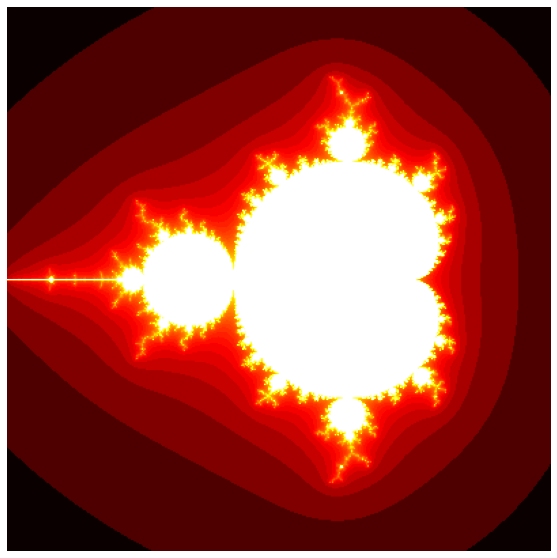

In [ ]:
m = mandelbrot_1(size, iterations)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.log(m), cmap=plt.cm.hot)
ax.set_axis_off()

In [ ]:
%timeit mandelbrot_1(size, iterations)

5.04 s ± 49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Adding `@njit` as a decorator gives a 300x speedup!

In [ ]:
@njit
def mandelbrot_2(size, iterations):
    m = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break
    return m

In [ ]:
%timeit mandelbrot_2(size, iterations)

16.6 ms ± 206 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Exercises

* An alternative measure of impurity is the so-called Shannon entropy, which measures the average information content of a message. In the context of classification, a set's entropy is zero when it contains examples of only one class. Use the definition of entropy 
$$ H_i = \sum_{k=1}^n p_{i,k} \log p_{i,k} $$
to extend our `DecisionTree` class with a new `criterion` hyperparameter that allows one to use Gini impurity or entropy as a measure of a node's impurity.
* In our implementation of `TreeEnsemble` we use all the features at every node to find the best split point. Extend the functionality by introducing a `max_features` hyperparameter that controls the number of features used at every node in a manner similar to scikit-learn.